<a href="https://colab.research.google.com/github/Smrutilipsanayak/FakeNewsDetection-main/blob/main/plant_disease_classification_Resnet50(98_16).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical

import numpy as np
from sklearn.metrics import classification_report
import os
from zipfile import ZipFile


In [ ]:
from google.colab import drive
import json
import os

# Mount Google Drive
drive.mount('/content/drive')

# Load Kaggle credentials
kaggle_json_path = "/content/drive/MyDrive/kaggle (1).json"  # Update to correct file path
kaggle_credentials = json.load(open(kaggle_json_path))

# Set Kaggle environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_credentials["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentials["key"]

# Download the dataset
!pip install kaggle
!kaggle datasets download -d alyeko/potato-tomato-dataset


Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/alyeko/potato-tomato-dataset
License(s): unknown
 97% 222M/229M [00:01<00:00, 136MB/s]
100% 229M/229M [00:01<00:00, 124MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Unzip the downloaded dataset
with ZipFile("potato-tomato-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("Potato-Tomato-Dataset")

# Define dataset directories
# Manually set paths for the training and validation directories
train_dir = "/content/Potato-Tomato-Dataset"
val_dir = "/content/Potato-Tomato-Dataset"

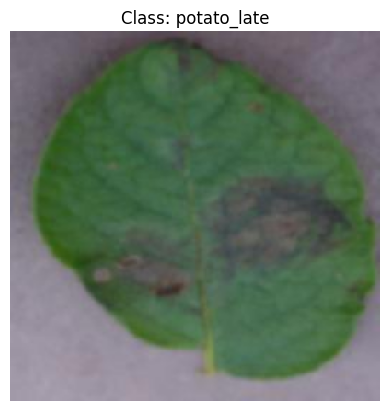

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Define the directory where the images are stored
train_dir = "Potato-Tomato-Dataset/idata/Image Dataset/ImageDataset/train"

# Get the list of subdirectories (classes) in the train directory
class_names = os.listdir(train_dir)

# Select a random class (subdirectory)
random_class = random.choice(class_names)

# Get the list of images in the selected class
class_dir = os.path.join(train_dir, random_class)
image_files = os.listdir(class_dir)

# Select a random image from the class
random_image = random.choice(image_files)

# Load the image using Keras' image module
img_path = os.path.join(class_dir, random_image)
img = image.load_img(img_path, target_size=(224, 224))  # Resize to the target size
img_array = image.img_to_array(img) / 255.0  # Convert to array and normalize

# Display the image using matplotlib
plt.imshow(img_array)
plt.title(f"Class: {random_class}")
plt.axis('off')  # Hide axes for a cleaner display
plt.show()


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Path to the original dataset
base_dir = "Potato-Tomato-Dataset/idata/Image Dataset/ImageDataset/train"
split_base_dir = "Potato-Tomato-Dataset/idata/Image Dataset/ImageDataset/split_data"

# Paths for split data
train_dir = os.path.join(split_base_dir, 'train')
val_dir = os.path.join(split_base_dir, 'valid')

# Create directories for train and validation splits
if not os.path.exists(split_base_dir):
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

# Detect class names from the original directory structure
class_names = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
print("Detected classes:", class_names)

# Split each class into 70% train and 30% validation
for class_name in class_names:
    class_dir = os.path.join(base_dir, class_name)
    images = os.listdir(class_dir)

    # Skip if the class directory is empty
    if not images:
        print(f"Warning: No images found in {class_name}, skipping.")
        continue

    train_images, val_images = train_test_split(images, test_size=0.3, random_state=42)

    # Create subdirectories for the class in train and validation dirs
    train_class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(val_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)

    # Move the files to respective directories
    for image in train_images:
        shutil.copy(os.path.join(class_dir, image), os.path.join(train_class_dir, image))
    for image in val_images:
        shutil.copy(os.path.join(class_dir, image), os.path.join(val_class_dir, image))

print("Dataset split completed!")

# Data generators with balanced augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True  # Ensure data is shuffled
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # No need to shuffle validation data
)

# Compute class weights based on the training data
true_labels = train_generator.classes  # Ground truth labels
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(true_labels),
    y=true_labels
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

# Optional: Save class weights for reuse
with open('class_weights.txt', 'w') as f:
    f.write(str(class_weights))


Detected classes: ['potato_early', 'tomato_healthy', 'tomato_late', 'potato_late', 'tomato_early', 'potato_healthy']
Dataset split completed!
Found 8403 images belonging to 6 classes.
Found 3606 images belonging to 6 classes.
Class weights: {0: 1.001788268955651, 1: 0.996797153024911, 2: 1.001788268955651, 3: 1.001788268955651, 4: 0.9989300998573466, 5: 0.9989300998573466}


In [ ]:
from tensorflow.keras.applications import ResNet50

# Load the ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Note the updated input size

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


# Add custom layers on top of base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert feature maps to a single vector
x = Dropout(0.5)(x)  # Add dropout to reduce overfitting
x = Dense(128, activation='relu')(x)  # Fully connected layer
predictions = Dense(6, activation='softmax')(x)  # Output layer for 6 classes

# Define final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers to retain pretrained weights during training
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,850,758 (90.98 MB)

 Trainable params: 263,046 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np

# Load the ResNet50 model pre-trained on ImageNet, excluding the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling to reduce dimensions
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Add dropout for regularization to prevent overfitting
predictions = Dense(train_generator.num_classes, activation='softmax')(x)  # Output layer for multi-class classification

# Combine the base model with the custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers to retain pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with an optimized learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0005),  # Reduced learning rate for stable training
    loss='categorical_crossentropy',      # Multi-class classification loss
    metrics=['accuracy']                  # Track accuracy
)

# Define callbacks for saving the best model and early stopping
checkpoint = ModelCheckpoint(
    filepath='best_resnet50_model.keras',  # Save the full model with `.keras` extension
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    save_weights_only=False               # Save the full model
)
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,  # Patience for early stopping
    verbose=1,
    restore_best_weights=True             # Restore the best weights after stopping
)

# Ensure all steps are included using `np.ceil`
steps_per_epoch = int(np.ceil(train_generator.samples / train_generator.batch_size))
validation_steps = int(np.ceil(val_generator.samples / val_generator.batch_size))

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,                            # Training epochs
    steps_per_epoch=steps_per_epoch,      # Correct total steps for training
    validation_steps=validation_steps,    # Correct total steps for validation
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

# Load the best saved model
model = tf.keras.models.load_model('best_resnet50_model.keras')

# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(val_generator, steps=validation_steps)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")



Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.7722 - loss: 0.6521
Epoch 1: val_accuracy improved from -inf to 0.94592, saving model to best_resnet50_model.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 142s 481ms/step - accuracy: 0.7726 - loss: 0.6511 - val_accuracy: 0.9459 - val_loss: 0.1555
Epoch 2/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9305 - loss: 0.2099
Epoch 3: val_accuracy improved from 0.94592 to 0.97060, saving model to best_resnet50_model.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 115s 427ms/step - accuracy: 0.9305 - loss: 0.2098 - val_accuracy: 0.9706 - val_loss: 0.0920
Epoch 4/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.9531 - loss: 0.1322
Epoch 5: val_accuracy did not improve from 0.97060
263/263 ━━━━━━━━━━━━━━━━━━━━ 115s 423ms/step - accuracy: 0.9531 - loss: 0.1322 - val_accuracy: 0.9687 - val_loss: 0.0896
Epoch 6/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 83us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9566 - loss: 0.1292
Epoch 7: val_accuracy improved from 0.97060 to 0.97698, saving model to best_resnet50_model.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 142s 428ms/step - accuracy: 0.9566 - l

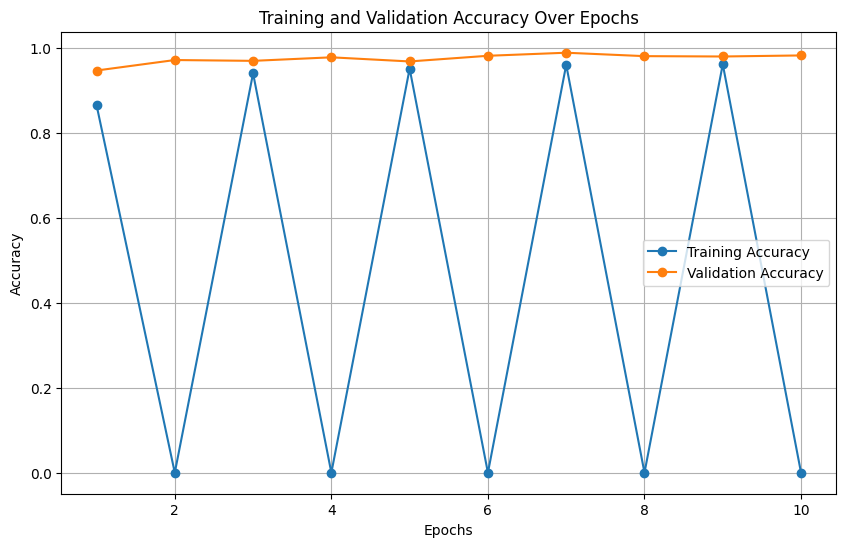

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation accuracy from the history object
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Check and align lengths
min_epochs = min(len(train_accuracy), len(val_accuracy))
train_accuracy = train_accuracy[:min_epochs]
val_accuracy = val_accuracy[:min_epochs]
epochs = range(1, min_epochs + 1)

# Plot the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')

# Add title, labels, and legend
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)

# Show the plot
plt.show()




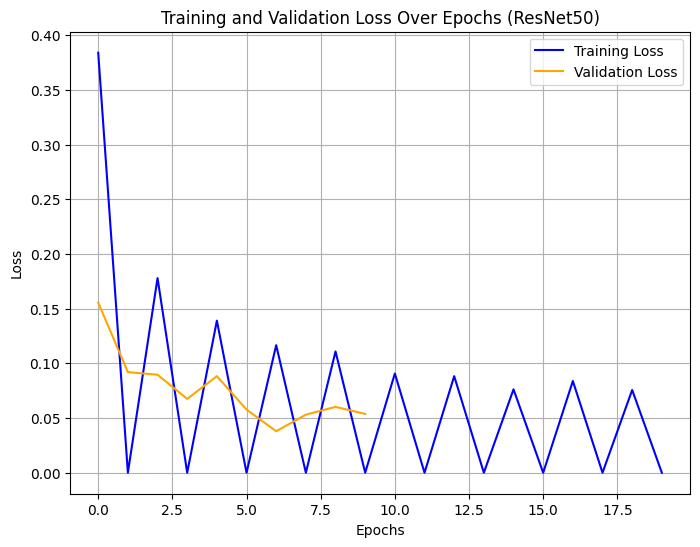

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation loss from the history object
# Assuming 'history' contains the training history for ResNet50
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(training_loss, label='Training Loss', color='blue')
plt.plot(validation_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs (ResNet50)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step
Classification Report (ResNet50):
                precision    recall  f1-score   support

  potato_early       1.00      0.98      0.99       600
potato_healthy       0.99      1.00      0.99       603
   potato_late       0.98      0.99      0.98       600
  tomato_early       0.98      0.98      0.98       600
tomato_healthy       1.00      1.00      1.00       601
   tomato_late       0.98      0.97      0.98       602

      accuracy                           0.99      3606
     macro avg       0.99      0.99      0.99      3606
  weighted avg       0.99      0.99      0.99      3606



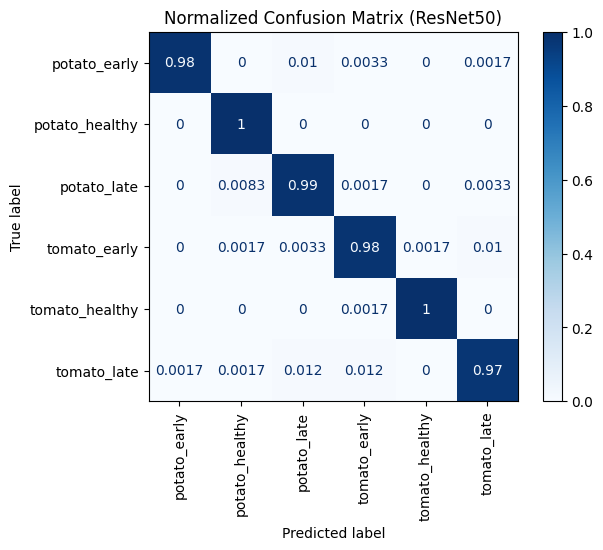

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict probabilities for the validation set using the ResNet50 model
predictions = model.predict(val_generator, steps=len(val_generator), verbose=1)
predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class indices

# Get true labels
true_labels = val_generator.classes  # Ground truth labels
class_indices = val_generator.class_indices  # Class to index mapping
classes = list(class_indices.keys())  # List of class names

# Classification report
print("Classification Report (ResNet50):")
print(classification_report(true_labels, predicted_labels, target_names=classes))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix / conf_matrix.sum(axis=1, keepdims=True),
                              display_labels=classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Normalized Confusion Matrix (ResNet50)")
plt.show()



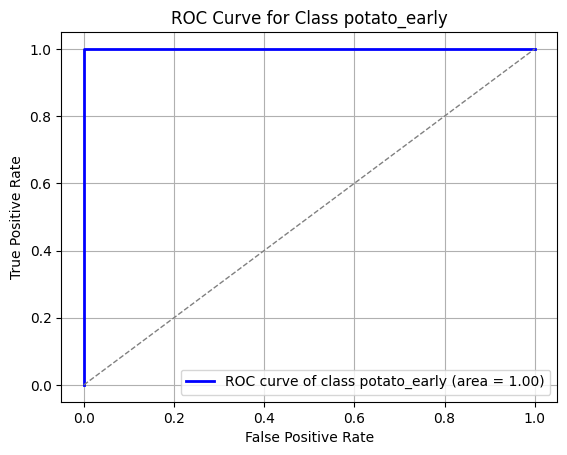

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming `true_labels`, `predictions`, and `classes` are already defined
# `true_labels` should contain the true class indices
# `predictions` should be the predicted probabilities for each class
# `classes` is a list of class names or indices

# One-hot encode the true labels
true_labels_one_hot = label_binarize(true_labels, classes=range(len(classes)))

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(true_labels_one_hot[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Specify the class index for which you want to plot the ROC curve
class_index = 0  # Change this index to the desired class
if class_index < 0 or class_index >= len(classes):
    raise ValueError("Invalid class index. Ensure it is within the range of classes.")

# Plot the ROC curve for the specified class
plt.figure()
plt.plot(fpr[class_index], tpr[class_index], color='blue', lw=2,
         label=f'ROC curve of class {classes[class_index]} (area = {roc_auc[class_index]:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.title(f'ROC Curve for Class {classes[class_index]}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



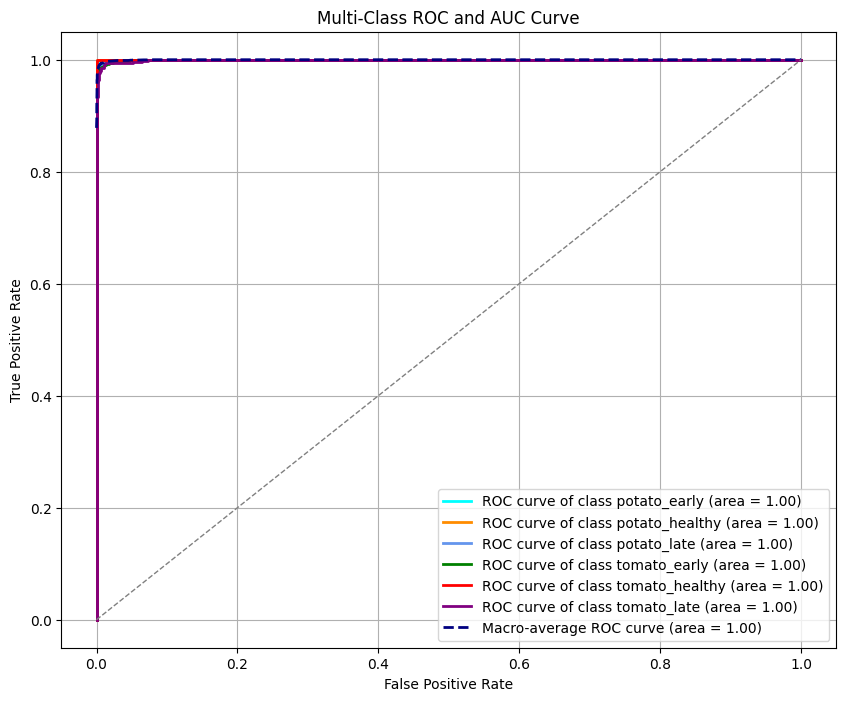

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

# Get the true labels as one-hot encoded
true_labels_one_hot = label_binarize(true_labels, classes=range(len(classes)))

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(true_labels_one_hot[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC and AUC
# Concatenate all FPRs and TPRs for all classes
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))

# Interpolate all ROC curves to compute the average TPR
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(classes)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= len(classes)

# Compute macro-average AUC
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))

# Plot ROC for each class
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')

# Plot macro-average ROC curve
plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle='--', lw=2,
         label=f'Macro-average ROC curve (area = {roc_auc["macro"]:0.2f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)

# Add title, labels, and legend
plt.title('Multi-Class ROC and AUC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average=None)

# Compute average values
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1 = np.mean(f1)

# Print the results
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-score: {avg_f1:.4f}")


Average Precision: 0.9878
Average Recall: 0.9878
Average F1-score: 0.9878
